# Importing modules

Let's first add these libraries to our project:

`numpy`: for matrix operations

`tensorlfow`: deep learning layers

`maplotlitb`: visualization

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py as h5
from tensorflow.python.framework import ops

# Steps for solving the problem

<ol>
    <li>Read data and format it.</li>
    <li>Use sliding window approach to augment data.</li>
    <li>Split data into training/dev/test sets.</li>
    <li>Create procedure for randomly initializing parameters with specified shape using Xavier's initialization.</li>
    <li>Create convolution and pooling procedures.</li>
    <li>Implement forward propagation.</li>
    <li>Implement cost function.</li>
    <li>Create model (uses Adam optimizer for minimization).</li>
    <li>Train model.</li>
    <li>Hyperparameter tuning using cross-validation sets.</li>
    <li>Retrain model until higher accuracy is achevied.</li>
</ol>

# Reading data

The sets in the dataset are divided into five categories.


SET A:	Z directory with	Z000.txt - Z100.txt<br>
SET B: 	O directory with	O000.txt - O100.txt<br>
SET C:	N directory with	N000.txt - N100.txt<br>
SET D:	F directory	with	F000.txt - F100.txt<br>
SET E:	S directory with	S000.txt - S100.txt<br>

In [2]:
datafile = "dataset/datafile512.h5"

with h5.File(datafile, 'r') as datafile:
    X_train = np.array(datafile['X_train'])
    Y_train = np.array(datafile['Y_train'])
    
    X_dev = np.array(datafile['X_dev'])
    Y_dev = np.array(datafile['Y_dev'])
    
    X_test = np.array(datafile['X_test'])
    Y_test = np.array(datafile['Y_test'])

In [3]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [4]:
X_train = make_dimensions_compatible(X_train)
X_dev = make_dimensions_compatible(X_dev)
X_test = make_dimensions_compatible(X_test)

In [5]:
print(X_train.shape)
print(Y_train.shape)

(25650, 512, 1)
(25650, 3)


In [6]:
X_train = X_train / 1000
X_dev = X_dev / 1000
X_test = X_test / 1000

# Initialization

WRITE TEXT HERE...

In [7]:
def initialize_parameters(parameter_shapes, parameter_values = {}):
    """
    Initializes weight parameters to build a neural network with tensorflow using Xaviar's initialization.
    The parameters are:
    parameter_shapes: a dictionary where keys represent tensorflow variable names, and values
    are shapes of the parameters in a list format
    Returns:
    params -- a dictionary of tensors containing parameters
    """
    
    params = { }
    
    for n,s in parameter_shapes.items():
        param = tf.get_variable(n, s, initializer = tf.contrib.layers.xavier_initializer())
        params[n] = param
    
    for n,v in parameter_values.items():
        params[n] = v
    
    return params

# Forward Propagation

WRITE TEXT HERE...

In [8]:
def forward_propagation(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training)
    # RELU
    A2 = tf.nn.relu(B2)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    A5 = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    return A5
    

In [9]:
tf.nn.conv1d?

# Computing cost function

WRITE TEXT HERE...

In [10]:
def compute_cost(X, Y, parameters, training):
    
    """
    Apply softmax to the output classes and find cross entropy loss
    X - Input data
    Y - One-hot output class training labels
    
    Returns:
    cost - cross entropy loss
    """
    
    Y_hat = forward_propagation(X, parameters, training=training)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_hat, labels=Y))
    
    return cost, Y_hat

# Pre-requisites for training

Here are some procedures that are necessary to execute before the actual training.

### Create placeholders

Tensorflow functions take input in the form of `feed_dict`. The variables in other functions are placeholders for the actual input.

In [11]:
def create_placeholders(n_x, n_y):
    """
    Creates Tensorflow placeholders that act for input data and their labels
    
    Arguments:
    n_x - no. of features for X
    n_x - no. of classes for Y
    
    Returns:
    X - placeholder for data that contains input featurs,
        shape: (no. of examples, no. of features). No. of examples is set to None
    Y - placeholder for data that contains output class labels,
        shape (no. of examples, no. of classes). No. of examples is set ot None
    """
    
    X = tf.placeholder(tf.float32, name='X', shape=(None, n_x, 1))
    Y = tf.placeholder(tf.float32, name='Y', shape=(None, n_y))
    is_train = tf.placeholder(tf.bool, name='is_train')
    
    return X,Y,is_train

### Parameter shapes

To initialize model parameters, we've created a procedure above. It takes as an argument a dictionary in which we supply the model parameter shapes.

In [12]:
def parameter_shapes():
    """
    Get tha shapes of all parameters used in the model.
    Convolutional layer parameter shapes (filters) are in list format
    
    Returns:
    param_shapes - dict that contains all the parameters as follows
    CONV1_W, CONV2_W, CONV3_W
    param_values:
    CONV1_Str, CONV2_Str, CONV3_Str,
    FC1_units, DO_prob, output_classes
    """
    
    param_shapes = {}
    param_values = {}

    # Conv Layer 1 parameter shapes
    # No. of channels: 24, Filter size: 5, Stride: 3
    param_shapes['CONV1_W'] = [5, 1, 24]
    param_values['CONV1_Str'] = 3
    
    # Conv Layer 2 parameter shapes
    # No. of channels: 16, Filter size: 3, Stride: 2
    param_shapes['CONV2_W'] = [3, 24, 16]
    param_values['CONV2_Str'] = 2
    
    # Conv Layer 3 parameter shapes
    # No. of channels: 8, Filter size: 3, Stride: 2
    param_shapes['CONV3_W'] = [3, 16, 8]
    param_values['CONV3_Str'] = 2
    
    # Fully connected layer 1 units = 20
    param_values['FC1_units'] = 20
    
    # Dropout layer after fully connected layer 1 probability
    param_values['DO_prob'] = 0.5
    
    # Fully connected layer 2 units (also last layer)
    # No. of units = no. of output classes = 3
    param_values['output_classes'] = 3
    
    return param_shapes, param_values

### Random mini-batches

For each epoch we'll use different sets of mini-batches to avoid any possible overfitting.

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, window size) (m, n_x)
    Y -- output classes, of shape (number of examples, output classes) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Training data

WRITE TEXT HERE...

[UPDATE_OPS](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm)

In [26]:
def plot_costs(costs, dev_costs, learning_rate):
    # plot the cost
    plt.plot(costs, color='blue', label='training')
    plt.plot(dev_costs, color='green', label='dev')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend()
    plt.show()

In [27]:
def model(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x,_) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    dev_costs = []
    
    # Create Placeholders of the correct shape
    X, Y, is_train = create_placeholders(n_x, n_y)

    # Initialize parameters
    param_shapes, param_values = parameter_shapes()
    parameters = initialize_parameters(param_shapes, param_values)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Prediction: Use Y_hat to compute the output class during prediction
    cost, Y_hat = compute_cost(X, Y, parameters, is_train)
    
    # For impementation of batch norm the tf.GraphKeys.UPDATE_OPS dependency needs to be added
    # see documentation on tf.contrib.layers.batch_norm
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Y_hat, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess, tf.control_dependencies(update_ops):
        
        # Run the initialization
        sess.run(init)
        
        print("Cost at start: %f" % cost.eval({X: X_train, Y: Y_train, is_train: False}))
        print("Dev cost: %f" % cost.eval({X: X_dev, Y: Y_dev, is_train: False}))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                
                try:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, is_train: True})

                    epoch_cost += minibatch_cost / num_minibatches
                
                # Implement early stopping mechanism on KeyboardInterrupt
                except KeyboardInterrupt:
                    print("KeyboardInterrupt received. Stopping early")
                    plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate)
                    return parameters
                

            # Save the costs after each epoch for plotting learning curve
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                dev_cost = cost.eval({X: X_dev, Y: Y_dev, is_train: False})
                dev_costs.append(dev_cost)
                
                
            # Print the cost every epoch
            if print_cost == True and (epoch + 1) % 5 == 0:
                print ("\nCost after epoch %i: %f" % (epoch + 1, epoch_cost))
                print ("Dev cost after epoch %i: %f" % (epoch + 1, dev_cost))
                
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
                dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
                print("Train Accuracy:", train_accuracy)
                print("Dev Accuracy:", dev_accuracy)
                
                
                
        plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate)

        # Calculate the correct predictions
#         predict_op = tf.argmax(Y_hat, 1)
#         correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
#         # Calculate accuracy on the test set
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
                
        return parameters
    
    

Cost at start: 1.102707
Dev cost: 1.105215
Train Accuracy: 0.38670567
Dev Accuracy: 0.408

Cost after epoch 5: 0.806574
Dev cost after epoch 5: 1.062213
Train Accuracy: 0.4633918
Dev Accuracy: 0.46133333

Cost after epoch 10: 0.615287
Dev cost after epoch 10: 1.036935
Train Accuracy: 0.4582846
Dev Accuracy: 0.45866665

Cost after epoch 15: 0.479126
Dev cost after epoch 15: 1.023886
Train Accuracy: 0.45754385
Dev Accuracy: 0.464

Cost after epoch 20: 0.431033
Dev cost after epoch 20: 1.026809
Train Accuracy: 0.4553996
Dev Accuracy: 0.464

Cost after epoch 25: 0.394382
Dev cost after epoch 25: 1.039372
Train Accuracy: 0.45212474
Dev Accuracy: 0.46133333

Cost after epoch 30: 0.369675
Dev cost after epoch 30: 1.050577
Train Accuracy: 0.43871346
Dev Accuracy: 0.44533333

Cost after epoch 35: 0.341556
Dev cost after epoch 35: 1.058440
Train Accuracy: 0.4348538
Dev Accuracy: 0.44266668

Cost after epoch 40: 0.323092
Dev cost after epoch 40: 1.063277
Train Accuracy: 0.42499027
Dev Accuracy: 0

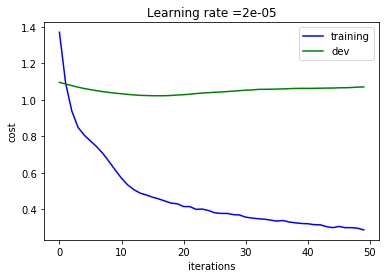

Train Accuracy: 0.4185185
Dev Accuracy: 0.41333333


In [28]:
parameters = model(X_train, Y_train, X_dev, Y_dev, learning_rate=0.00002, num_epochs=50)

In [261]:
parameters

{'CONV1_W': <tf.Variable 'CONV1_W:0' shape=(5, 1, 24) dtype=float32_ref>,
 'CONV2_W': <tf.Variable 'CONV2_W:0' shape=(3, 24, 16) dtype=float32_ref>,
 'CONV3_W': <tf.Variable 'CONV3_W:0' shape=(3, 16, 8) dtype=float32_ref>,
 'CONV1_Str': 3,
 'CONV2_Str': 2,
 'CONV3_Str': 2,
 'FC1_units': 20,
 'DO_prob': 0.5,
 'output_classes': 3}

In [269]:
saver = tf.train.Saver({"parameters": parameters})
save_filename = "parameters-0.00002.ckpt"
with tf.Session() as saver_sess:
    save_path = saver.save(saver_sess, "train/" + save_filename)

TypeError: Failed to convert object of type <class 'dict'> to Tensor. Contents: {'CONV1_W': <tf.Variable 'CONV1_W:0' shape=(5, 1, 24) dtype=float32_ref>, 'CONV2_W': <tf.Variable 'CONV2_W:0' shape=(3, 24, 16) dtype=float32_ref>, 'CONV3_W': <tf.Variable 'CONV3_W:0' shape=(3, 16, 8) dtype=float32_ref>, 'CONV1_Str': 3, 'CONV2_Str': 2, 'CONV3_Str': 2, 'FC1_units': 20, 'DO_prob': 0.5, 'output_classes': 3}. Consider casting elements to a supported type.

In [272]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(train_vars))

[array([[[ 0.1643085 ,  0.02832928,  0.00959623, -0.1577815 ,
          0.18924351, -0.01189184, -0.01866665, -0.0223477 ,
         -0.08435522,  0.14691184, -0.02915606,  0.11074157,
          0.20260207,  0.20071696, -0.1872986 ,  0.12060685,
         -0.01182598,  0.12479548,  0.15796684,  0.0713618 ,
         -0.09553804,  0.09870629, -0.08830424, -0.02101901]],

       [[-0.16887933,  0.16461147, -0.17514198,  0.0358382 ,
          0.12785394, -0.0477768 , -0.09394044, -0.06481086,
          0.20126636, -0.14165503,  0.09850214,  0.19882835,
          0.19975846,  0.03520782, -0.0587478 , -0.07248875,
          0.11210789,  0.17382033, -0.17019679, -0.13251658,
         -0.05781738,  0.08353408,  0.15923844, -0.03437892]],

       [[-0.01887622, -0.00399101, -0.03537577, -0.00912465,
         -0.05754562,  0.13235386, -0.21564794, -0.09492114,
          0.10254969,  0.11964042, -0.16168648, -0.10999942,
          0.05496974,  0.01924798,  0.134133  ,  0.18148993,
         -0.05380